In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import stats, signal, special, interpolate
import hera_cal as hc
import hera_pspec as hp
import healpy
import hera_sim as hs
import h5py
from memory_profiler import memory_usage
import uvtools as uvt
from cube2hpx import cube2hpx
import healvis as hv
from healvis.data import DATA_PATH
import os
from pyuvdata import UVData, UVBeam, utils as uvutils

/Users/nkern/Software/anaconda3/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/Users/nkern/Software/anaconda3/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/Users/nkern/Software/anaconda3/lib/python3.7/site-packages/hera_sim/__init__.py:36: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the way in which hera_sim methods are interfaced with; in particular, changes will be made such that the

# Sky Simulation

## 1. Generate mock 21 cm healpix maps

In [122]:
# initialize cosmology
C = hp.conversions.Cosmo_Conversions()

In [123]:
# setup box
Npix = 256
dx = 4.0  # Mpc

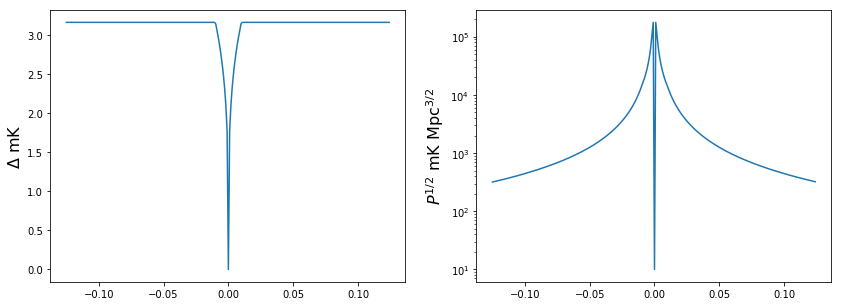

In [124]:
# define power spectra
k = np.fft.fftshift(np.fft.fftfreq(Npix, d=dx))
kx,ky,kz = np.meshgrid(k, k, k)
kmag = np.sqrt(kx**2 + ky**2 + kz**2)
Dk = np.sqrt(kmag).clip(1e-10, 1e0).astype(np.complex) * 1e8
Dk[Dk>10e6] = 10e6
#Dk = (kmag ** 3 * 1e8).astype(np.complex).clip(1e-4)
p = np.exp(1j*stats.uniform.rvs(0, 2*np.pi, Npix**3)).reshape(Npix, Npix, Npix)
Dk *= p
Pk = Dk / (kmag**3 / (2*np.pi**2)).clip(1e-10,)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ax = axes[0]
ax.plot(k, np.sqrt(np.abs(Dk[128, 128])) / 1e3)
ax.set_ylabel(r'$\Delta$ mK', fontsize=16)
ax = axes[1]
ax.plot(k, np.sqrt(np.abs(Pk[128, 128])) / 1e3)
ax.set_ylabel(r'$P^{1/2}$ mK Mpc$^{3/2}$', fontsize=16)
ax.set_yscale('log')

In [125]:
# generate cube
sim = np.real(np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(Pk / np.sqrt(np.abs(Pk))), norm='ortho'))) / Npix**3

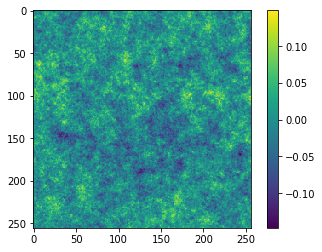

In [126]:
# plot
plt.imshow(sim[:, :, 128])
plt.colorbar()

In [5]:
# generate freqs
freqs = np.linspace(120e6, 140e6, 128, endpoint=False)

In [128]:
# tile onto healpix
m = np.asarray([cube2hpx(sim, f/1e6, nside=64, sim_res=dx, sim_size=(Npix, Npix, Npix)) for f in freqs])

In [129]:
del sim, kmag, kx, ky, kz

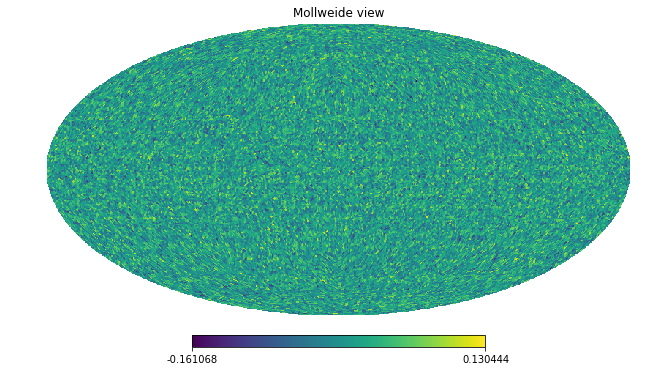

In [130]:
healpy.mollview(m[-1])

In [131]:
sky = hv.sky_model.SkyModel()
sky.set_data(m[:, :, None].T)
sky.freqs = freqs
del m

In [132]:
sky.write_hdf5('../data/eor_sky.h5', clobber=True)

...writing ../data/eor_sky.h5


## 2. Generate GSM healpix maps

In [136]:
gsm = hv.sky_model.gsm_shell(64, freqs)

In [137]:
sky = hv.sky_model.SkyModel()
sky.set_data(gsm[None, :, :])
sky.freqs = freqs

In [138]:
sky.write_hdf5("../data/gsm_sky.h5", clobber=True)

...writing ../data/gsm_sky.h5


In [139]:
sky = hv.sky_model.SkyModel()
sky.read_hdf5('../data/gsm_sky.h5')

...reading ../data/gsm_sky.h5


In [109]:
# load full object, get reds
uvd = hv.simulator.setup_uvdata(array_layout=os.path.join(DATA_PATH, "configs/HERA65_layout.csv"),
                                telescope_location=(-30.72152777777791, 21.428305555555557, 1073.0000000093132),
                                telescope_name="HERA", Ntimes=1, time_cadence=1, start_time=2458000.53,
                                pols=['xx'], run_check=True, freq_array=sky.freqs, make_full=False)
reds, lens, angs = hp.utils.get_reds(uvd, bl_len_range=(10, 40))
inds = [ind for ind in np.arange(len(reds)) if len(reds[ind]) > 5]
reds, lens, angs = [reds[i] for i in inds], [lens[i] for i in inds], [angs[i] for i in inds]
print(len(reds))
bls = [red[0] for red in reds] + [(0, 0)]

Nbls: 2080
15


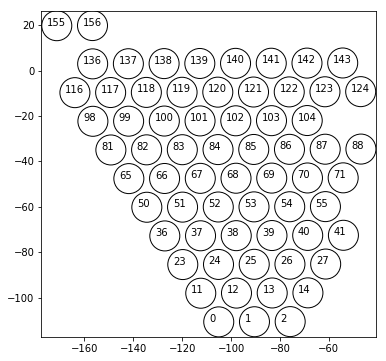

In [140]:
antpos, ants = uvd.get_ENU_antpos()
plt.figure(figsize=(6,6))
plt.scatter(antpos[:, 0], antpos[:, 1], facecolor='', edgecolor='k', s=900)
for i, a in enumerate(ants):
    plt.text(antpos[i,0]-4,antpos[i,1],a,fontsize=10,color='k')

In [174]:
# setup empty uvdata
uvd = hv.simulator.setup_uvdata(array_layout=os.path.join(DATA_PATH, "configs/HERA65_layout.csv"),
                                telescope_location=(-30.72152777777791, 21.428305555555557, 1073.0000000093132),
                                telescope_name="HERA", Ntimes=20, time_cadence=800.0, start_time=2458000.53,
                                pols=['xx'], bls=bls, run_check=True, freq_array=sky.freqs, make_full=True)
uvd.write_uvh5('../data/eor_sim.uvh5', clobber=True)

Nbls: 15
File exists; clobbering


In [175]:
# setup empty uvdata
uvd = hv.simulator.setup_uvdata(array_layout=os.path.join(DATA_PATH, "configs/HERA65_layout.csv"),
                                telescope_location=(-30.72152777777791, 21.428305555555557, 1073.0000000093132),
                                telescope_name="HERA", Ntimes=20, time_cadence=800.0, start_time=2458000.53,
                                pols=['xx'], bls=bls, run_check=True, freq_array=sky.freqs, make_full=True,
                                no_autos=False)
uvd.write_uvh5('../data/gsm_sim.uvh5', clobber=True)

Nbls: 16
File exists; clobbering


In [140]:
# get beam
beam = hv.beam_model.PowerBeam('../data/NF_HERA_CST_DIPOLE.beamfits')

In [141]:
# smooth beam and interpolate to freqs
beam.smooth_beam(freqs, inplace=True, freq_ls=4.0)

In [176]:
# get analytic beam
beam = hv.beam_model.AnalyticBeam('airy', diameter=14.0)

In [177]:
# run simulation
freq_chans = np.arange(len(freqs))
hv.simulator.run_simulation_partial_freq(freq_chans, '../data/eor_sim.uvh5', '../data/eor_sky.h5',
                                         fov=180, beam=beam)

...reading ../data/eor_sky.h5
Finished: 1, Elapsed 0.05min, Remain 0.017hour, MaxRSS 6.787072GB
Finished: 2, Elapsed 0.10min, Remain 0.015hour, MaxRSS 273.784832GB
Finished: 3, Elapsed 0.15min, Remain 0.014hour, MaxRSS 274.90304GB
Finished: 4, Elapsed 0.20min, Remain 0.013hour, MaxRSS 275.554304GB
Finished: 5, Elapsed 0.25min, Remain 0.012hour, MaxRSS 275.951616GB
Finished: 6, Elapsed 0.29min, Remain 0.011hour, MaxRSS 276.35712GB
Finished: 7, Elapsed 0.34min, Remain 0.010hour, MaxRSS 276.926464GB
Finished: 8, Elapsed 0.38min, Remain 0.010hour, MaxRSS 277.307392GB
Finished: 9, Elapsed 0.43min, Remain 0.009hour, MaxRSS 277.74976GB
Finished: 10, Elapsed 0.47min, Remain 0.008hour, MaxRSS 278.134784GB
Finished: 11, Elapsed 0.52min, Remain 0.007hour, MaxRSS 278.704128GB
Finished: 12, Elapsed 0.57min, Remain 0.006hour, MaxRSS 279.10144GB
Finished: 13, Elapsed 0.64min, Remain 0.006hour, MaxRSS 279.523328GB
Finished: 14, Elapsed 0.74min, Remain 0.005hour, MaxRSS 279.904256GB
Finished: 15, Elaps

In [178]:
# run simulation
freq_chans = np.arange(len(freqs))
hv.simulator.run_simulation_partial_freq(freq_chans, '../data/gsm_sim.uvh5', '../data/gsm_sky.h5',
                                         fov=180, beam=beam)

...reading ../data/gsm_sky.h5
Finished: 1, Elapsed 0.06min, Remain 0.020hour, MaxRSS 6.795264GB
Finished: 2, Elapsed 0.12min, Remain 0.018hour, MaxRSS 274.10432GB
Finished: 3, Elapsed 0.18min, Remain 0.017hour, MaxRSS 275.136512GB
Finished: 4, Elapsed 0.24min, Remain 0.016hour, MaxRSS 275.787776GB
Finished: 5, Elapsed 0.30min, Remain 0.015hour, MaxRSS 276.303872GB
Finished: 6, Elapsed 0.36min, Remain 0.014hour, MaxRSS 276.721664GB
Finished: 7, Elapsed 0.42min, Remain 0.013hour, MaxRSS 277.17632GB
Finished: 8, Elapsed 0.49min, Remain 0.012hour, MaxRSS 277.56544GB
Finished: 9, Elapsed 0.55min, Remain 0.011hour, MaxRSS 277.97504GB
Finished: 10, Elapsed 0.61min, Remain 0.010hour, MaxRSS 278.396928GB
Finished: 11, Elapsed 0.67min, Remain 0.009hour, MaxRSS 278.81472GB
Finished: 12, Elapsed 0.73min, Remain 0.008hour, MaxRSS 279.343104GB
Finished: 13, Elapsed 0.79min, Remain 0.007hour, MaxRSS 279.744512GB
Finished: 14, Elapsed 0.86min, Remain 0.006hour, MaxRSS 280.158208GB
Finished: 15, Elapse

In [9]:
# make noise
uvd = UVData()
uvd.read("../data/gsm_sim.uvh5")
uvn = uvd.select(bls=[bl for bl in uvd.get_antpairs() if bl[0] != bl[1]], inplace=False)

In [10]:
omega_p = hs.noise.bm_poly_to_omega_p(freqs/1e9)

In [12]:
autoK = uvd.get_data(0,0,'xx') * hs.noise.jy2T(freqs/1e9, omega_p) / 1e3
lsts = np.unique(uvd.lst_array)
Trxr = 150
np.random.seed(0)
for i, ap in enumerate(uvn.get_antpairs()):
    inds = uvn.antpair2ind(ap)
    uvn.data_array[inds, 0, :, 0] = hs.noise.sky_noise_jy(autoK + Trxr, freqs/1e9, lsts, omega_p, inttime=10.7)

In [13]:
uvn.write_uvh5("../data/noise_sim.uvh5", clobber=True)

File exists; clobbering


## 3. Inspect

In [183]:
uvd = UVData()
uvd.read('../data/gsm_sim.uvh5', bls=[(0, 1)])
uvd2 = UVData()
uvd2.read("../data/eor_sim.uvh5", bls=[(0, 1)])
uvd3 = UVData()
uvd3.read("../data/noise_sim.uvh5", bls=[(0, 1)])
uvd.data_array += uvd2.data_array + uvd3.data_array / 1e2

In [184]:
F = hc.frf.FRFilter(uvd)
E = hc.frf.FRFilter(uvd2)
N = hc.frf.FRFilter(uvd3)

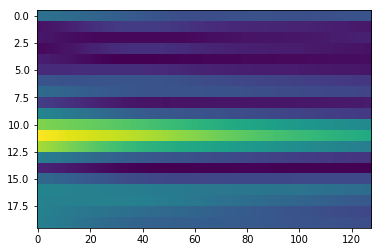

In [186]:
plt.imshow(np.abs(F.data[(0,1,'xx')]), aspect='auto')

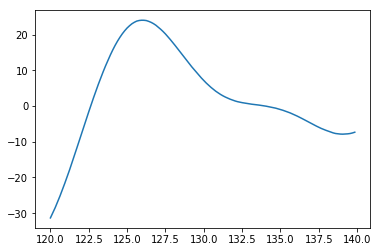

In [187]:
plt.plot(F.freqs/1e6, F.data[(0,1,'xx')][0].real)

In [188]:
F.fft_data(window='bh7', overwrite=True)
E.fft_data(window='bh7', overwrite=True)

In [189]:
t2k = C.tau_to_kpara(C.f2z(np.mean(freqs)))

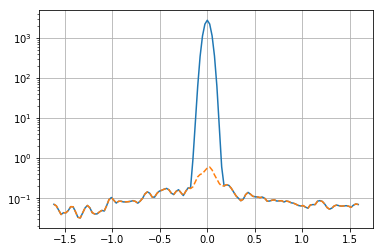

In [190]:
plt.plot(F.delays*t2k/1e9, np.mean(np.abs(F.dfft[(0,1,'xx')]), axis=0))
plt.plot(F.delays*t2k/1e9, np.mean(np.abs(E.dfft[(0,1,'xx')]), axis=0), ls='--')
plt.yscale('log')
plt.grid()